In [18]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# General libraries
import string
from collections import Counter

# Data manipulation & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Scikit-learn libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
df = pd.read_csv('/content/combined_emotion.csv')

## EDA

In [3]:
# Show 5 random rows
df.sample(5)

,sentence,emotion
208091,i feel dismayed i begin to suspect myself susp...,sad
104351,i don t think i have ever been that tired with...,joy
377624,i feel a little more sarcastic than usual and ...,anger
310772,i explained that no one ever respects me and i...,sad
353758,i really don t like him that way but i don t w...,love


In [4]:
print(f"Dataframe size: {df.shape}")

# Check for NaN values
print(df.isnull().sum())

Dataframe size: (422746, 2)
sentence    0
emotion     0
dtype: int64


Perfect! Data is full.

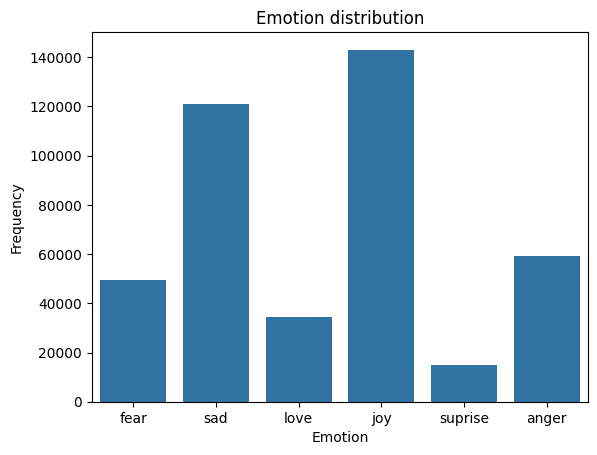

In [5]:
# Show emotion distribution
sns.countplot(data=df, x='emotion')
plt.title('Emotion distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

It is noticeable that there is a **class imbalance**. It might be necessary to account for this by using class weights or applying oversampling/undersampling techniques in the future.

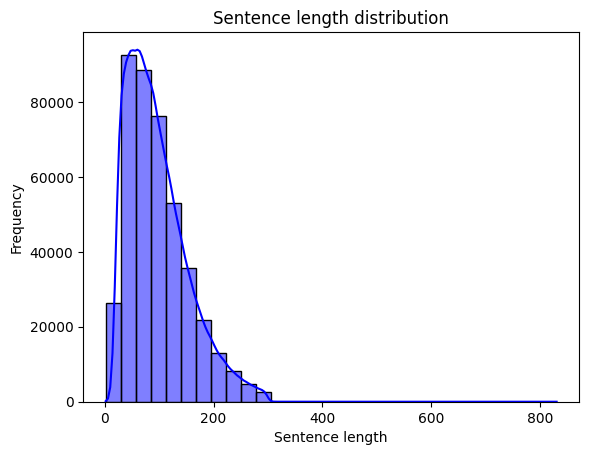

count    422746.000000
mean         97.033980
std          56.198156
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: sentence_length, dtype: float64


In [6]:
# Add column with sentence length (including spaces)
df['sentence_length'] = df['sentence'].apply(len)

# Show distribution of sentence length
sns.histplot(df['sentence_length'], bins=30, kde=True, color='blue')
plt.title('Sentence length distribution')
plt.xlabel('Sentence length')
plt.ylabel('Frequency')
plt.show()

# Show sentence length statistics
print(df['sentence_length'].describe())

There are both very long sentences (830 characters) and very short ones (2 characters).

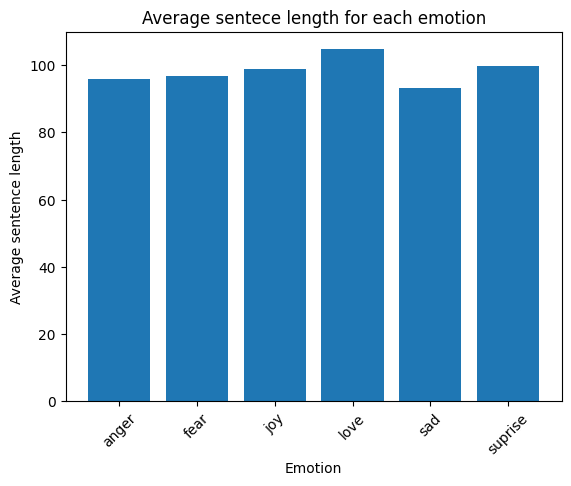

In [7]:
# Calculate average sentece length for each emotion
avg_length_by_emotion = df.groupby('emotion')['sentence_length'].mean().reset_index()

# Show average sentece length for each emotion
plt.bar(avg_length_by_emotion['emotion'], avg_length_by_emotion['sentence_length'])
plt.xlabel("Emotion")
plt.ylabel("Average sentence length")
plt.title("Average sentece length for each emotion")
plt.xticks(rotation=45)
plt.show()

The average sentence length across all emotions is uniformly distributed.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


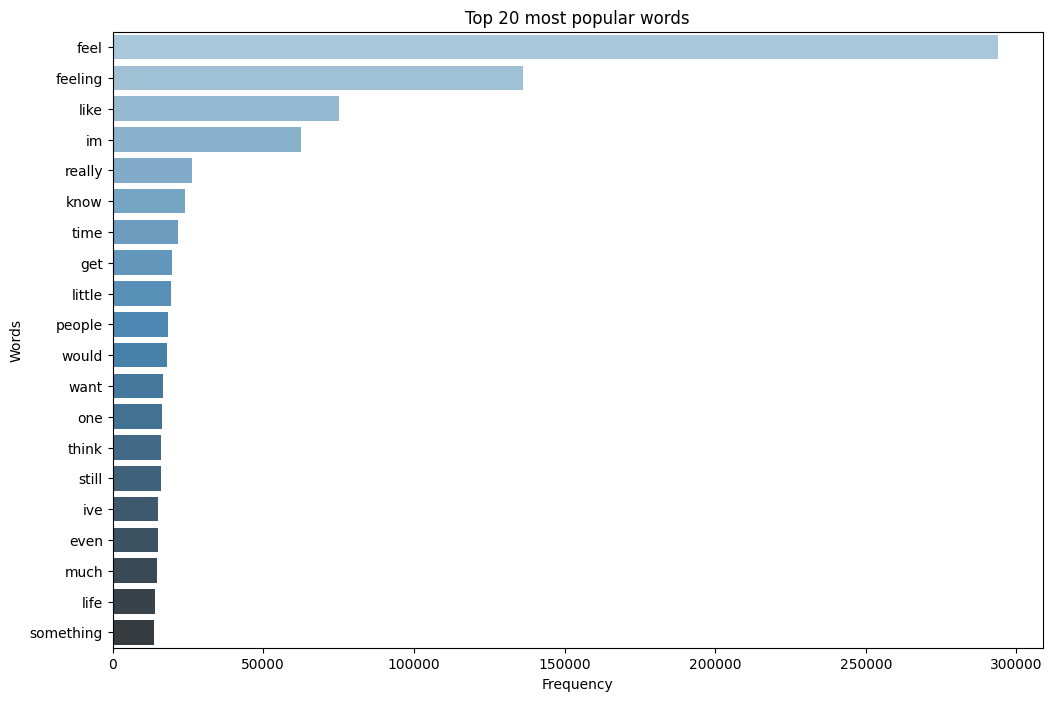

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
MAX_WORDS = 20 # number of most popular words

def preprocess_text(text):
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize sentences
    tokens = word_tokenize(text)
    # Delete stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

all_words = []
for sentence in df['sentence']:
    all_words.extend(preprocess_text(sentence))

# Find most popular (frequent) words
word_freq = Counter(all_words)
common_words = word_freq.most_common(MAX_WORDS)

x = [word[1] for word in common_words] # popular words
y = [word[0] for word in common_words] # frequency of popular words

plt.figure(figsize=(12, 8))
sns.barplot(x=x, y=y, palette='Blues_d')
plt.title(f'Top {MAX_WORDS} most popular words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

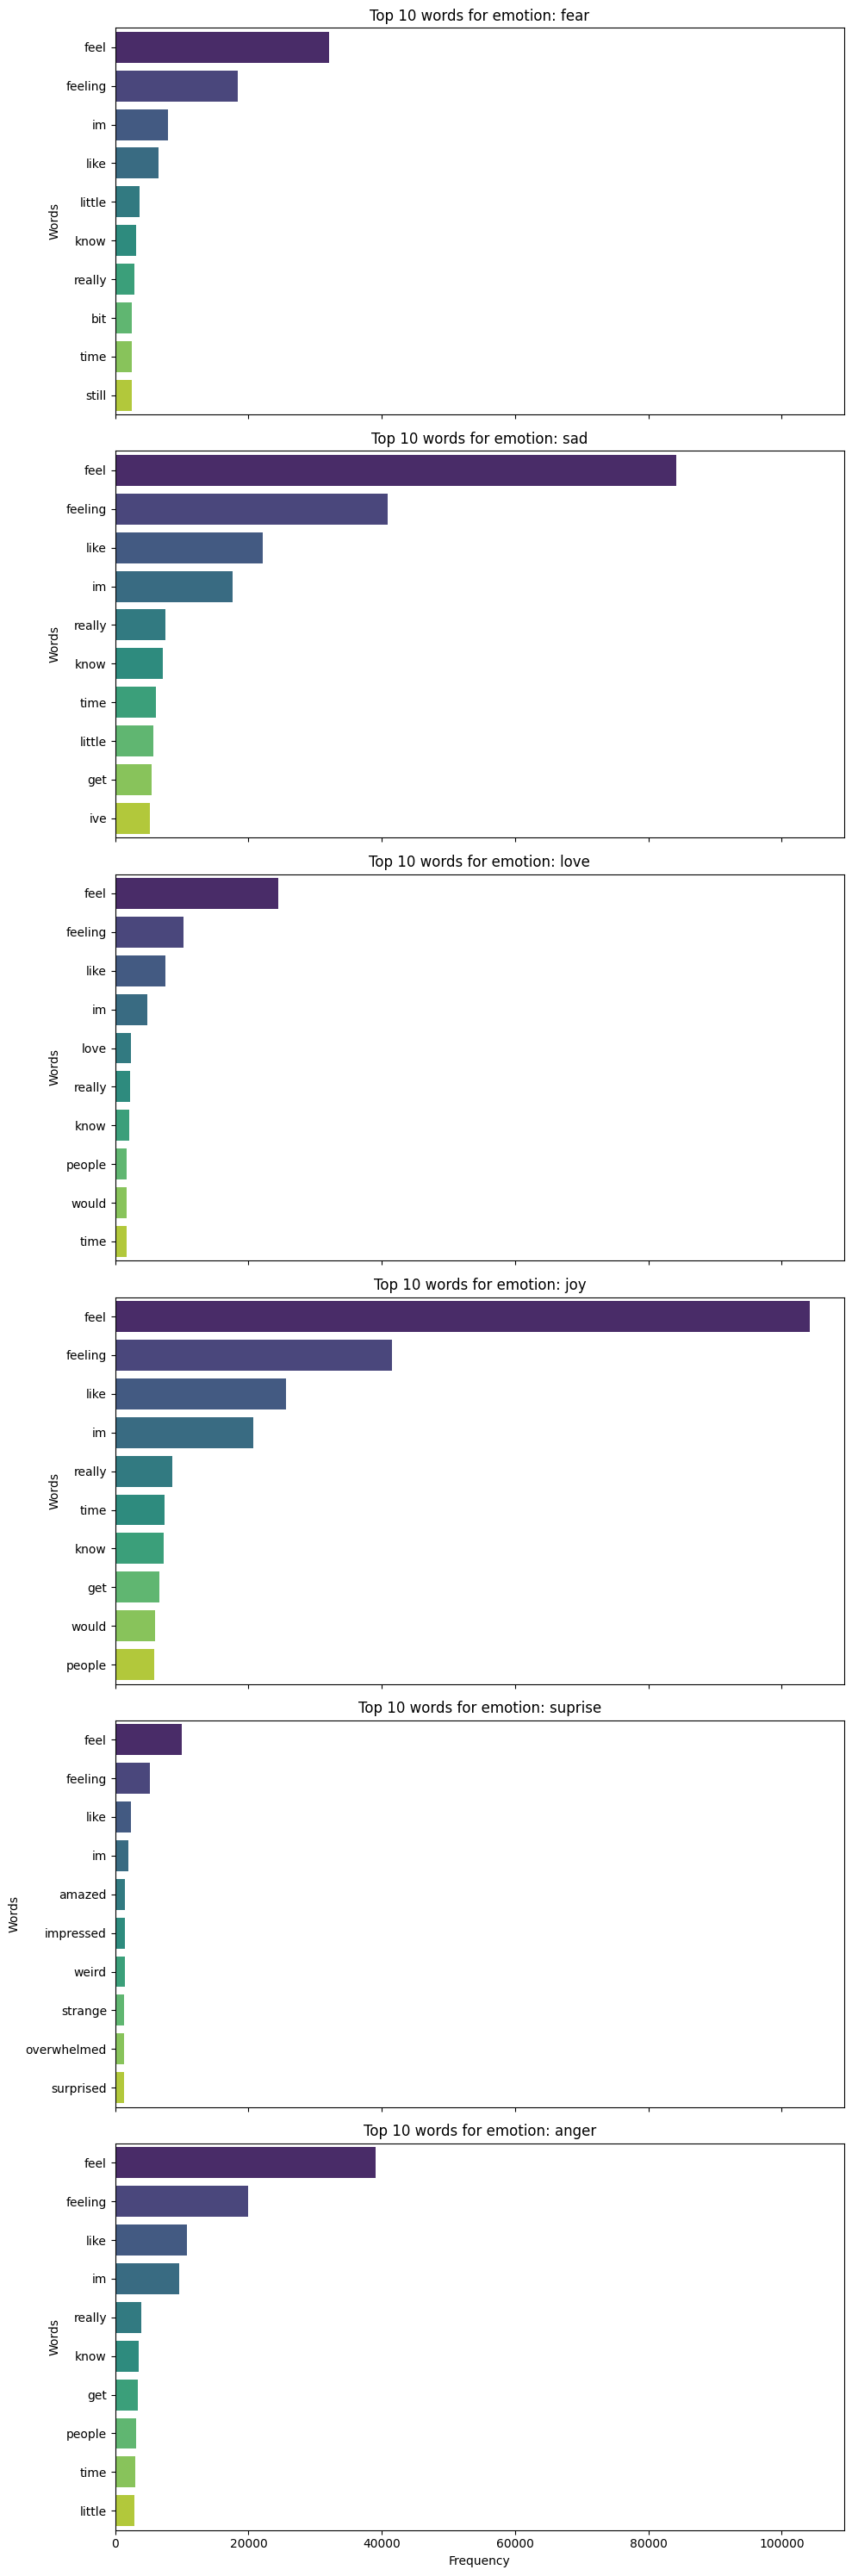

In [20]:
# Calculate frequency of popular words for each emotion
emotion_word_freq = {}
for emotion in df['emotion'].unique():
    # Filter by emotions
    subset = df[df['emotion'] == emotion]['sentence']
    words = []
    for sentence in subset:
        words.extend(preprocess_text(sentence))
    emotion_word_freq[emotion] = Counter(words).most_common(10)

# Show frequency of popular words for each emotion
num_emotions = len(emotion_word_freq)
fig, axes = plt.subplots(nrows=num_emotions, figsize=(10, 5 * num_emotions), sharex=True)

for i, (emotion, freq) in enumerate(emotion_word_freq.items()):
    words, counts = zip(*freq)  # seperate words from their frequency
    ax = axes[i] if num_emotions > 1 else axes
    sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=ax)
    ax.set_title(f'Top 10 words for emotion: {emotion}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')

plt.tight_layout()
plt.show()

There are many descriptions of emotions (such as "feel," "feeling") and numerous words indicating subjective experience (like "im," "ive"). Due to preprocessing, these should have been "I'm," "I've" ⇔ "I am," "I have." It might be necessary to handle this properly in the future.

In [21]:
sub_df = df.groupby('emotion').sample(n=2000, random_state=42)
sub_df = sub_df.reset_index(drop=True)
print(sub_df.head())

                                            sentence emotion  sentence_length
0                              i am feeling tortured   anger               21
1  i drink a full cup of coffee i become what i f...   anger              104
2  i know people have already given her hell for ...   anger              120
3  i feel sickened by and disgusted with the sins...   anger               79
4  i havent worked out today but i feel like im j...   anger              143


In [22]:
df=sub_df

In [23]:

X = df["sentence"]
y = df["emotion"]

# Split on train and test (stratification is needed due to imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Consider class weights in logreg
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6870833333333334

Classification report:
               precision    recall  f1-score   support

       anger       0.63      0.58      0.60       400
        fear       0.84      0.71      0.77       400
         joy       0.49      0.53      0.51       400
        love       0.89      0.86      0.88       400
         sad       0.44      0.49      0.46       400
     suprise       0.89      0.95      0.92       400

    accuracy                           0.69      2400
   macro avg       0.70      0.69      0.69      2400
weighted avg       0.70      0.69      0.69      2400



In [24]:
def transform_text(text):
    text = text.lower()
    text = word_tokenize(text)  # Tokenize text

    y = [word for word in text if word.isalnum()]  # Keep only alphanumeric tokens

    y = [word for word in y if word not in stopwords.words('english') and word not in string.punctuation]  # Remove stopwords

    y = [ps.stem(word) for word in y]  # Apply stemming

    return " ".join(y)


In [25]:
df['clean_sentence']=df["sentence"].apply(transform_text)

In [26]:
df.sample(5)

,sentence,emotion,sentence_length,clean_sentence
4222,im feeling generous ill give you a story as well,joy,48,im feel gener ill give stori well
3882,i turn in the child support papers and i feel ...,fear,76,turn child support paper feel hesit done
11946,i feel dazed and confused about some of the,suprise,43,feel daze confus
7787,i feel that probably the most romantic thing t...,love,214,feel probabl romant thing anyon ever perform u...
2756,i was feeling at my most overwhelmed and burde...,fear,105,feel overwhelm burden medit turn help draw


In [27]:
# Seperate sentences and target
X = df["clean_sentence"]
y = df["emotion"]

# Split on train and test (stratification is needed due to imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Consider class weights in logreg
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=200)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8408333333333333

Classification report:
               precision    recall  f1-score   support

       anger       0.85      0.84      0.84       400
        fear       0.86      0.82      0.84       400
         joy       0.77      0.80      0.78       400
        love       0.86      0.87      0.86       400
         sad       0.83      0.76      0.79       400
     suprise       0.89      0.96      0.92       400

    accuracy                           0.84      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.84      0.84      0.84      2400



In [35]:
# Features & Labels
Xfeatures = df['clean_sentence']
ylabels = df['emotion']

In [36]:
#  Split Data
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=42)

In [37]:
# Build Pipeline
from sklearn.pipeline import Pipeline

In [38]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [39]:
# LogisticRegression Pipeline
pipe_lr = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC()),
    ('knn', KNeighborsClassifier())
])

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

ps = PorterStemmer()

# Custom Transformer Class
class TextTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting required for text transformation

    def transform(self, X):
        return [self._preprocess(text) for text in X]

    def _preprocess(self, text):
        text = text.lower()
        text = word_tokenize(text)

        y = [word for word in text if word.isalnum()]  # Keep only alphanumeric tokens

        y = [word for word in y if word not in stopwords.words('english') and word not in string.punctuation]  # Remove stopwords

        y = [ps.stem(word) for word in y]  # Apply stemming

        return " ".join(y)

# Create Pipeline
pipe_lr = Pipeline(steps=[
    ('transform_text', TextTransformer()),  # Use custom transformer
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('lr', LogisticRegression()),
])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
# Train and Fit Data
pipe_lr.fit(x_train,y_train)

Pipeline(steps=[('transform_text', TextTransformer()),
                ('tfidf', TfidfVectorizer(max_features=3000)),
                ('lr', LogisticRegression())])

In [42]:
pipe_lr

Pipeline(steps=[('transform_text', TextTransformer()),
                ('tfidf', TfidfVectorizer(max_features=3000)),
                ('lr', LogisticRegression())])

In [43]:
# Check Accuracy
pipe_lr.score(x_test,y_test)

0.8533333333333334

In [100]:
# Make A Prediction
ex1 = "i feel a tender touch in the heart"

In [101]:
pipe_lr.predict([ex1])

array(['love'], dtype=object)